# Graph Neural Network Feature Importance Analysis

This notebook implements a GNN-based approach to analyze feature importance for graph property prediction using two methods:
1. Perturbation Analysis - Measures impact of perturbing individual features
2. Hybrid Analysis - Combines perturbation results with focused feature subset testing

## Imports
<!-- This program uses a Graph Neural Network (GNN) to analyze and predict graph properties. It specifically focuses on understanding the relationships between different network metrics and how they influence each other. 

This is accomplished using a technique called Normalized Perturbation Analysis which we use to measure feature importance by systematically modifying input features and observing the impact on the model's predictions. You can specify any single graph property and the program will analyze all other features, ranking them in how important they are to predicting the specified feature. -->

In [53]:
# Version 2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.stats import spearmanr
import networkx as nx
import numpy as np
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Working on segmenting from monolithic structure as this file is getting too lengthy
from utils.model import SingleFeatureGNNModel
# from utils.graph import generate_graph, process_graph_data
# from utils.analysis import calculate_perturbation_importance, calculate_hybrid_importance
# from utils.visualization import plot_training_progress, plot_method_comparison
# from utils.config import MODEL_CONFIG, TRAINING_CONFIG, ANALYSIS_CONFIG, FEATURE_NAMES

## Feature Definitions
Import all graph features used in the analysis, including node-level and global properties. Also import all the configuration options for the program.

In [54]:
import json
from pathlib import Path

def load_config():
    """Load configuration from config.json"""
    # When running in Jupyter notebook, use current working directory
    config_path = Path.cwd() / 'utils' / 'config.json'
    
    try:
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        # Generate feature names programmatically from config
        node_metrics = config['features']['node_metrics']
        global_metrics = config['features']['global_metrics']
        num_nodes = config['features']['num_nodes']
        prefix = config['features']['feature_naming']['node_prefix']
        separator = config['features']['feature_naming']['separator']
        
        FEATURE_NAMES = [
            f"{prefix}{i+1}{separator}{metric}" 
            for i in range(num_nodes)
            for metric in node_metrics
        ] + global_metrics
        
        return config, FEATURE_NAMES
    
    except FileNotFoundError:
        print(f"Config file not found at {config_path}")
        print("Current working directory:", Path.cwd())
        raise
    except json.JSONDecodeError:
        print(f"Error parsing config file at {config_path}")
        raise
    except KeyError as e:
        print(f"Missing required key in config file: {e}")
        raise

# Load configuration
CONFIG, FEATURE_NAMES = load_config()

# Create convenience variables
MODEL_CONFIG = CONFIG['model']
TRAINING_CONFIG = CONFIG['training']
ANALYSIS_CONFIG = CONFIG['analysis']
NODE_METRICS = CONFIG['features']['node_metrics']
GLOBAL_METRICS = CONFIG['features']['global_metrics']


## Model Training
Here we will train the model declared in model.py

In [55]:
def train_single_feature_model(model, data, target_idx):
    """Train model with configured parameters"""
    optimizer_class = getattr(optim, TRAINING_CONFIG['optimizer']['type'])
    optimizer = optimizer_class(
        model.parameters(),
        lr=TRAINING_CONFIG['learning_rate'],
        weight_decay=TRAINING_CONFIG['weight_decay'],
        betas=(TRAINING_CONFIG['optimizer']['beta1'], 
            TRAINING_CONFIG['optimizer']['beta2']),
        eps=TRAINING_CONFIG['optimizer']['eps']
    )
    
    criterion = nn.MSELoss()
    losses = []
    
    # Initialize tracking variables
    best_loss = float('inf')
    best_model = None
    patience_counter = 0
    
    for epoch in range(TRAINING_CONFIG['num_epochs']):
        # Training phase
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        train_loss = criterion(
            output, 
            data.original_features[target_idx].reshape(-1, 1)
        )
        
        # Backward pass
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_output = model(data)
            val_loss = criterion(
                val_output, 
                data.original_features[target_idx].reshape(-1, 1)
            )
        
        # Early stopping check
        early_stop_cfg = TRAINING_CONFIG['early_stopping']
        if early_stop_cfg['enabled']:
            if val_loss < best_loss - early_stop_cfg['min_delta']:
                best_loss = val_loss
                best_model = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= early_stop_cfg['patience']:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Progress logging
        if epoch % 5 == 0:
            print(f"Epoch {epoch:3d}: Train Loss = {train_loss:.4f}, "
                  f"Val Loss = {val_loss:.4f}")
        
        losses.append({
            'epoch': epoch,
            'train_loss': train_loss.item(),
            'val_loss': val_loss.item()
        })
    
    # Load best model if early stopping was enabled
    if early_stop_cfg['enabled'] and best_model is not None:
        model.load_state_dict(best_model)
    
    return losses, model

## Data Processing and Graph Generation
Functions for creating random graphs and computing their properties.

In [56]:
def generate_graph(num_nodes=100, edge_prob=0.05):
    """Generate a random graph ensuring it has at least one connected component of size 4"""
    while True:
        G = nx.erdos_renyi_graph(n=num_nodes, p=edge_prob)
        connected_nodes = find_connected_subgraph(G, size=4)
        if connected_nodes is not None:
            return G, connected_nodes

def process_graph_data(G, selected_nodes, target_idx):
    """Process graph data with proper node-wise feature variation"""
    # Compute features
    all_features = compute_features(G, selected_nodes)
    
    if not isinstance(all_features, torch.Tensor):
        all_features = torch.tensor(all_features, dtype=torch.float)
    
    num_nodes = len(G)
    num_features = len(FEATURE_NAMES) - 1
    x = torch.zeros((num_nodes, num_features))
    
    # Add node-wise variation to features
    current_idx = 0
    for i in range(len(FEATURE_NAMES)):
        if i != target_idx:
            base_value = all_features[i].clone()
            # Create node-specific variations
            variations = torch.randn(num_nodes) * 0.1  # 10% variation
            node_values = base_value + variations
            # Ensure values stay in reasonable range
            node_values = torch.clamp(node_values, min=0.0, max=1.0)
            x[:, current_idx] = node_values
            current_idx += 1
    
    # Prepare edge index
    edge_list = list(G.edges())
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    # Create data object
    data = Data(
        x=x,
        edge_index=edge_index,
        original_features=all_features
    )
    
    print("\nData Processing Debug:")
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of features: {num_features}")
    print(f"Feature tensor shape: {x.shape}")
    print(f"Edge index shape: {edge_index.shape}")
    print(f"Sample feature means: {x.mean(dim=0)[:5]}")
    print(f"Sample feature stds: {x.std(dim=0)[:5]}")
    
    return data

def compute_features(G, nodes):
    if nodes is None or len(nodes) != 4:
        raise ValueError("Must provide exactly 4 nodes for feature computation")
    
    features = []
    n_nodes = len(G)

    def normalize_metric_dict(metric_dict, min_val=0.1):
        """Normalize dictionary values to [min_val, 1] range."""
        values = np.array(list(metric_dict.values()))
        min_metric = np.min(values)
        max_metric = np.max(values)
        
        if max_metric == min_metric:
            return {k: min_val for k in metric_dict.keys()}
            
        normalized = {
            k: min_val + (v - min_metric) * (1 - min_val) / (max_metric - min_metric)
            for k, v in metric_dict.items()
        }
        return normalized
    
    # Pre-compute and normalize all centrality metrics
    try:
        # Compute and normalize basic centrality metrics
        betweenness = normalize_metric_dict(nx.betweenness_centrality(G))
        closeness = normalize_metric_dict(nx.closeness_centrality(G))
        pagerank = normalize_metric_dict(nx.pagerank(G))
        core_numbers = normalize_metric_dict(nx.core_number(G))
        degrees = normalize_metric_dict(dict(G.degree()))
        
        # Custering computation and normalization
        clustering = nx.clustering(G)
        clustering = normalize_metric_dict(clustering)
        
        # Handle eigenvector centrality for largest component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        eigenvector = nx.eigenvector_centrality_numpy(subgraph)
        min_eigen = min(eigenvector.values())
        eigenvector.update({n: min_eigen for n in G.nodes() if n not in eigenvector})
        eigenvector = normalize_metric_dict(eigenvector)
        
    except Exception as e:
        print(f"Error computing centrality metrics: {str(e)}")
        raise
    
    # Process each node
    for node in nodes:
        # Calculate neighbor-based metrics
        neighbors = list(G.neighbors(node))
        avg_neighbor_degree = (
            np.mean([degrees[n] for n in neighbors]) 
            if neighbors else 0.1  # Use minimum value if no neighbors
        )
        
        # Compile node features
        node_features = [
            degrees[node],
            clustering[node],
            avg_neighbor_degree,
            betweenness[node],
            closeness[node],
            pagerank[node],
            core_numbers[node],
            compute_local_efficiency(G, node),
            eigenvector[node]
        ]
        features.extend(node_features)
    
    # Compute and normalize global features
    global_features = [
        nx.density(G),
        nx.average_clustering(G),
        nx.average_shortest_path_length(G) / n_nodes if nx.is_connected(G) else 0.1,
        nx.degree_assortativity_coefficient(G),
        nx.transitivity(G),
        len(list(nx.connected_components(G))) / n_nodes,
        max(degrees.values()),
        min(degrees.values()),
        np.mean(list(degrees.values())),
        nx.global_efficiency(G)
    ]
    
    # Normalize global features
    global_features = normalize_metric_dict(
        {str(i): v for i, v in enumerate(global_features)}
    ).values()
    
    features.extend(global_features)
    return torch.tensor(features, dtype=torch.float32)

def find_connected_subgraph(G, size=4):
    """Find a connected subgraph of specified size"""
    for component in nx.connected_components(G):
        subgraph = G.subgraph(component)
        if len(subgraph) >= size:
            start_node = np.random.choice(list(subgraph.nodes()))
            nodes = list(nx.bfs_tree(subgraph, start_node))[:size]
            return nodes
    return None

def compute_local_efficiency(G, node):
    """
    Compute local efficiency for a node in the graph
    """
    neighbors = list(G.neighbors(node))
    if len(neighbors) < 2:
        return 0.0
    
    # Create subgraph of node's neighbors
    subgraph = G.subgraph(neighbors)
    if len(subgraph) < 2:
        return 0.0
    
    try:
        # Calculate average shortest path length in subgraph
        avg_path_length = nx.average_shortest_path_length(subgraph)
        return 1.0 / avg_path_length if avg_path_length > 0 else 0.0
    except nx.NetworkXError:
        # Handle disconnected graphs
        return 0.0

## Feature Importance Analysis Methods
Implementation of both perturbation and hybrid analysis approaches

In [57]:
def calculate_perturbation_importance(model, data, target_idx, feature_names, n_trials=5):
    """Perturbation-based feature importance analysis"""
    model.eval()
    importances = []
    base_prediction = model(data).detach()
    base_mse = torch.mean((base_prediction - data.original_features[target_idx])**2)
    
    num_features = data.x.size(1)
    
    for i in range(num_features):
        impact_scores = []
        for scale in ANALYSIS_CONFIG['perturbation']['scales']:
            for _ in range(n_trials):
                perturbed_data = data.clone()
                original_values = perturbed_data.x[:, i].clone()
                
                # Controlled perturbation
                noise = torch.randn_like(original_values) * original_values.std() * scale
                perturbed_values = original_values + noise
                perturbed_values = (perturbed_values - perturbed_values.mean()) / (perturbed_values.std() + 1e-8)
                perturbed_values = perturbed_values * original_values.std() + original_values.mean()
                
                perturbed_data.x[:, i] = perturbed_values
                
                with torch.no_grad():
                    prediction = model(perturbed_data)
                    mse = torch.mean((prediction - data.original_features[target_idx])**2)
                    relative_impact = (mse / base_mse - 1.0).item()
                    impact_scores.append(relative_impact)
        
        importance = np.percentile(impact_scores, 75)
        importances.append((feature_names[i], importance))
    
    return importances

def calculate_hybrid_importance(model, data, feature_idx, target_idx, n_trials=5):
    """Calculate hybrid importance with debug messages"""
    impacts = []
    base_pred = model(data).detach()
    base_mse = torch.mean((base_pred - data.original_features[target_idx].reshape(-1, 1))**2)
    
    # print(f"\nDebugging Hybrid Analysis for feature index {feature_idx}")
    # print(f"Base MSE: {base_mse:.6f}")
    
    for trial in range(n_trials):
        masked_data = data.clone()
        original = masked_data.x[:, feature_idx].clone()
        
        # Random masking with debugging
        mask = torch.rand_like(original)
        masked_values = original * mask
        
        # print(f"\nTrial {trial + 1}:")
        # print(f"Original stats - Mean: {original.mean():.4f}, Std: {original.std():.4f}")
        # print(f"Masked stats - Mean: {masked_values.mean():.4f}, Std: {masked_values.std():.4f}")
        
        masked_data.x[:, feature_idx] = masked_values
        
        with torch.no_grad():
            masked_pred = model(masked_data)
            masked_mse = torch.mean((masked_pred - data.original_features[target_idx].reshape(-1, 1))**2)
            relative_impact = (masked_mse / base_mse - 1.0).item()
            impacts.append(relative_impact)
            # print(f"Relative impact: {relative_impact:.4f}")
    
    mean_impact = np.mean(impacts)
    # print(f"\nFinal mean impact: {mean_impact:.4f}")
    return mean_impact

## Feature Importance Analysis
Functions for analyzing feature importance through perturbation.

In [58]:
def normalize_scores(scores, target_range=(-1, 1)):
    """Normalize scores to consistent range"""
    min_val, max_val = min(scores), max(scores)
    return [
        target_range[0] + (x - min_val) * (target_range[1] - target_range[0]) / (max_val - min_val)
        for x in scores
    ]

def analyze_feature_importance(model, data, target_idx, feature_names, n_trials=5):
    """Perturbation-based feature importance analysis"""
    model.eval()
    importances = []
    base_prediction = model(data).detach()
    base_mse = torch.mean((base_prediction - data.original_features[target_idx].reshape(-1, 1))**2)
    
    # print(f"\nDebugging Feature Importance Analysis:")
    # print(f"Base MSE: {base_mse:.6f}")
    # print(f"Target feature: {feature_names[target_idx]}")
    
    num_features = data.x.size(1)
    
    for i in range(num_features):
        impact_scores = []
        feature_name = feature_names[i]
        
        # print(f"\nAnalyzing feature: {feature_name}")
        # print(f"Original feature stats - Mean: {data.x[:, i].mean():.4f}, Std: {data.x[:, i].std():.4f}")
        
        for scale in [0.1, 0.3, 0.5]:
            scale_impacts = []
            for trial in range(n_trials):
                perturbed_data = data.clone()
                original = perturbed_data.x[:, i].clone()
                
                # Controlled perturbation
                noise = torch.randn_like(original) * original.std() * scale
                perturbed = original + noise
                perturbed = (perturbed - perturbed.mean()) / (perturbed.std() + 1e-8)
                perturbed = perturbed * original.std() + original.mean()
                
                perturbed_data.x[:, i] = perturbed
                
                with torch.no_grad():
                    pred = model(perturbed_data)
                    mse = torch.mean((pred - data.original_features[target_idx].reshape(-1, 1))**2)
                    impact = abs(mse - base_mse) / (base_mse + 1e-8)
                    scale_impacts.append(impact.item())
            
            avg_scale_impact = np.mean(scale_impacts)
            # print(f"Scale {scale:.1f} - Avg Impact: {avg_scale_impact:.4f}")
            impact_scores.extend(scale_impacts)
        
        importance = np.percentile(impact_scores, 75)
        # print(f"Final importance score: {importance:.4f}")
        importances.append((feature_names[i], importance))
    
    # Normalize and print final scores
    scores = [score for _, score in importances]
    normalized_scores = normalize_scores(scores)
    importances = [(f, s) for (f, _), s in zip(importances, normalized_scores)]
    
    print("\nFinal normalized scores:")
    for feat, score in sorted(importances, key=lambda x: x[1], reverse=True)[:5]:
        print(f"{feat}: {score:.4f}")
    
    return sorted(importances, key=lambda x: x[1], reverse=True)

## Comparison Analysis
Compare results from both approaches

In [59]:
def compare_analysis_methods(G, selected_nodes, target_feature, top_k=5):
    """Compare perturbation and hybrid analysis results"""
    target_idx = FEATURE_NAMES.index(target_feature)
    data = process_graph_data(G, selected_nodes, target_idx)
    
    # Train model
    model = SingleFeatureGNNModel(node_feature_dim=len(FEATURE_NAMES)-1)
    
    # Perturbation analysis
    pert_importances = analyze_feature_importance(model, data, target_idx, FEATURE_NAMES)
    
    # Get top features
    pert_importances.sort(key=lambda x: x[1], reverse=True)
    top_features = pert_importances[:top_k]
    
    # Hybrid analysis on top features
    hybrid_importances = {}
    for idx, (feature, _) in enumerate(top_features):
        importance = calculate_hybrid_importance(model, data, idx, target_idx)
        hybrid_importances[feature] = importance
    
    # Display results
    print(f"\n=== Feature Importance Analysis for {target_feature} ===")
    headers = ["Rank", "Feature", "Perturbation Score", "Hybrid Score"]
    table_data = []
    
    for i, (feature, pert_score) in enumerate(top_features):
        hybrid_score = hybrid_importances.get(feature, 0)
        table_data.append([i+1, feature, f"{pert_score:.4f}", f"{hybrid_score:.4f}"])
    
    print(tabulate(table_data, headers=headers, tablefmt="pipe"))
    
    # Create and display visualization
    fig = plot_method_comparison(pert_importances[:top_k], hybrid_importances)
    plt.show()
    
    return pert_importances[:top_k], hybrid_importances

## Training Visualization
Add visualization function to track training and validation losses over epochs.

In [60]:
def plot_training_progress(losses):
    """Training visualization"""
    
    epochs = [d['epoch'] for d in losses]
    train_losses = [d['train_loss'] for d in losses]
    val_losses = [d['val_loss'] for d in losses]
    
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss', alpha=0.7)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', alpha=0.3)
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.legend()
    plt.title('Training Progress - Validation Loss')
    plt.tight_layout()
    plt.show()

## Compare Perturbation vs Hybrid Methods

In [61]:
def compare_analysis_methods(G, selected_nodes, target_feature, top_k=10):
    """Compare perturbation and hybrid analysis results with consistency scoring"""
    target_idx = FEATURE_NAMES.index(target_feature)
    data = process_graph_data(G, selected_nodes, target_idx)
    
    # Train model
    model = SingleFeatureGNNModel(node_feature_dim=len(FEATURE_NAMES)-1)
    losses, model = train_single_feature_model(model, data, target_idx)
    
    # Run both analyses
    pert_importances = analyze_feature_importance(model, data, target_idx, FEATURE_NAMES)
    hybrid_importances = {}
    for idx, (feature, _) in enumerate(pert_importances):
        importance = calculate_hybrid_importance(model, data, idx, target_idx)
        hybrid_importances[feature] = importance
    
    # Normalize scores
    norm_pert, norm_hybrid = normalize_comparison_scores(pert_importances, hybrid_importances)
    
    # Calculate consistency scores
    consistency_scores = {}
    for feature in norm_pert.keys():
        p_score = norm_pert[feature]
        h_score = norm_hybrid[feature]
        
        # Calculate consistency components
        magnitude_diff = abs(abs(p_score) - abs(h_score))
        sign_agreement = int(p_score * h_score > 0)
        rank_diff = abs(
            sorted(norm_pert.keys(), key=lambda x: abs(norm_pert[x]), reverse=True).index(feature) -
            sorted(norm_hybrid.keys(), key=lambda x: abs(norm_hybrid[x]), reverse=True).index(feature)
        ) / len(norm_pert)
        
        consistency_scores[feature] = 1 - (
            0.4 * magnitude_diff +
            0.4 * (1 - sign_agreement) +
            0.2 * rank_diff
        )
    
    # Generate results table
    print(f"\n=== Feature Importance Analysis for {target_feature} ===")
    headers = ["Rank", "Feature", "Perturbation", "Hybrid", "Consistency"]
    
    # Sort by consistency score
    sorted_features = sorted(
        consistency_scores.keys(),
        key=lambda x: consistency_scores[x],
        reverse=True
    )[:top_k]
    
    table_data = [
        [i+1, feature,
         f"{norm_pert[feature]:6.3f}",
         f"{norm_hybrid[feature]:6.3f}",
         f"{consistency_scores[feature]:6.3f}"]
        for i, feature in enumerate(sorted_features)
    ]
    
    print(tabulate(table_data, headers=headers, tablefmt="pipe"))
    
    # Print summary statistics
    metrics = calculate_agreement_metrics(pert_importances, hybrid_importances)
    print("\nSummary Statistics:")
    print(f"Mean Consistency: {np.mean(list(consistency_scores.values())):.3f}")
    print(f"Std Consistency: {np.std(list(consistency_scores.values())):.3f}")
    print(f"Rank Correlation: {metrics['rank_correlation']:.3f}")

    export_feature_importance_comparison(pert_importances, hybrid_importances)
    
    # Create visualizations
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(2, 2, figure=fig)
    
    # Method comparison plot (top row, spans both columns)
    ax1 = fig.add_subplot(gs[0, :])
    
    # Create new comparison plot directly
    features = sorted(norm_pert.keys(), 
                     key=lambda x: abs(norm_pert[x] - norm_hybrid[x]))
    x = np.arange(len(features))
    width = 0.35
    
    ax1.bar(x - width/2, [norm_pert[f] for f in features], width, label='Perturbation')
    ax1.bar(x + width/2, [norm_hybrid[f] for f in features], width, label='Hybrid')
    ax1.set_xticks(x)
    ax1.set_xticklabels(features, rotation=45, ha='right')
    ax1.set_ylabel('Normalized Importance Score')
    ax1.set_title('Method Comparison (Sorted by Score Agreement)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Scatter plot (bottom left)
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.scatter(list(norm_pert.values()), list(norm_hybrid.values()), alpha=0.6)
    for feat in norm_pert.keys():
        ax2.annotate(feat, (norm_pert[feat], norm_hybrid[feat]), fontsize=8)
    ax2.set_xlabel('Perturbation Score')
    ax2.set_ylabel('Hybrid Score')
    ax2.set_title('Score Correlation')
    ax2.grid(True)
    
    # Add diagonal line for perfect correlation
    lims = [
        min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
        max(ax2.get_xlim()[1], ax2.get_ylim()[1]),
    ]
    ax2.plot(lims, lims, 'k--', alpha=0.5, label='Perfect Agreement')
    ax2.legend()
    
    # Heatmap (bottom right)
    ax3 = fig.add_subplot(gs[1, 1])
    sorted_features = sorted_features[:top_k]  # Use top k features
    heatmap_data = pd.DataFrame({
        'Perturbation': [norm_pert[f] for f in sorted_features],
        'Hybrid': [norm_hybrid[f] for f in sorted_features]
    }, index=sorted_features)
    
    sns.heatmap(
        heatmap_data,
        cmap='RdBu_r',
        center=0,
        annot=True,
        fmt='.2f',
        ax=ax3,
        cbar_kws={'label': 'Normalized Importance Score'}
    )
    ax3.set_title('Most Consistent Features Heatmap')
    
    plt.tight_layout()
    plt.show()
    
    return pert_importances, hybrid_importances, consistency_scores

def normalize_comparison_scores(pert_results, hybrid_results):
    """Normalize scores from both methods to [-1, 1] range"""
    # Convert perturbation results to dict
    pert_dict = {}
    for feat, score in pert_results:
        pert_dict[feat] = score
    
    # Get common features
    common_features = set(pert_dict.keys()) & set(hybrid_results.keys())
    
    # Normalize perturbation scores
    pert_values = [pert_dict[f] for f in common_features]
    max_pert = max(pert_values)
    min_pert = min(pert_values)
    norm_pert = {f: (2 * (pert_dict[f] - min_pert) / (max_pert - min_pert) - 1) 
                 for f in common_features}
    
    # Normalize hybrid scores
    hybrid_values = [hybrid_results[f] for f in common_features]
    max_abs_hybrid = max(abs(min(hybrid_values)), abs(max(hybrid_values)))
    norm_hybrid = {f: hybrid_results[f] / max_abs_hybrid 
                  for f in common_features}
    
    return norm_pert, norm_hybrid

def calculate_agreement_metrics(pert_results, hybrid_results):
    """Calculate agreement metrics between perturbation and hybrid methods"""
    # Convert perturbation results to dict if needed
    pert_dict = {feat: score for feat, score in pert_results}
    
    # Calculate per-feature agreement scores
    agreements = {}
    for feature in pert_dict.keys():
        p_score = pert_dict[feature]
        h_score = hybrid_results[feature]
        # Calculate agreement based on magnitude and sign
        magnitude_diff = abs(abs(p_score) - abs(h_score))
        sign_agreement = int(p_score * h_score > 0)
        agreements[feature] = magnitude_diff * sign_agreement
    
    # Calculate summary metrics
    metrics = {
        'mean_agreement': np.mean(list(agreements.values())),
        'rank_correlation': spearmanr(
            [pert_dict[f] for f in pert_dict.keys()],
            [hybrid_results[f] for f in pert_dict.keys()]
        )[0]
    }
    # Removed 'high_agreement_ratio' since we're not using that categorization
    return metrics

def export_feature_importance_comparison(pert_results, hybrid_results, save_path='feature_importance.csv'):
    """
    Export feature importance comparison to CSV with correlation scores.
    
    Args:
        pert_results: List of (feature, score) tuples from perturbation analysis
        hybrid_results: Dictionary of feature:score pairs from hybrid analysis
        save_path: Path to save the CSV file
    """
    # Convert perturbation results to dictionary
    pert_dict = {feat: score for feat, score in pert_results}
    
    # Create DataFrame
    df = pd.DataFrame({
        'Feature': list(pert_dict.keys()),
        'Perturbation_Score': list(pert_dict.values()),
        'Hybrid_Score': [hybrid_results[feat] for feat in pert_dict.keys()]
    })
    
    # Calculate correlation between methods for each feature
    df['Correlation'] = df.apply(
        lambda row: abs(row['Perturbation_Score'] * row['Hybrid_Score']) / 
        (abs(row['Perturbation_Score']) * abs(row['Hybrid_Score']) + 1e-8), 
        axis=1
    )
    
    # Sort by absolute perturbation score
    df = df.sort_values('Perturbation_Score', key=abs, ascending=False)
    
    # Save to CSV
    df.to_csv(save_path, index=False)
    
    return df

## Perturbation vs Hybrid Visualization

In [62]:
def plot_method_comparison(pert_results, hybrid_results):
    """Create visual comparison of methods with alignment-based sorting"""
    norm_pert, norm_hybrid = normalize_comparison_scores(pert_results, hybrid_results)
    
    # Calculate alignment scores and sort features
    features = list(norm_pert.keys())
    alignment_scores = [(f, abs(norm_pert[f] - norm_hybrid[f])) for f in features]
    sorted_features = [f for f, _ in sorted(alignment_scores, key=lambda x: x[1])]
    
    pert_scores = [norm_pert[f] for f in sorted_features]
    hybrid_scores = [norm_hybrid[f] for f in sorted_features]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Bar plot - show all 46 features
    x = np.arange(len(sorted_features))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, pert_scores, width, label='Perturbation')
    bars2 = ax1.bar(x + width/2, hybrid_scores, width, label='Hybrid')
    
    # Rotate and align the tick labels so they look better
    ax1.set_xticks(x)
    ax1.set_xticklabels(sorted_features, rotation=45, ha='right')
    
    # Add a legend
    ax1.set_ylabel('Normalized Importance Score')
    ax1.set_title('Method Comparison (Sorted by Score Agreement)')
    ax1.legend()
    
    # Add grid for better readability
    ax1.grid(True, alpha=0.3)
    
    # Add alignment score annotation
    for idx, (feat, align_score) in enumerate(alignment_scores):
        ax1.text(idx, min(pert_scores[idx], hybrid_scores[idx]) - 0.1, 
                f'{align_score:.2f}', 
                rotation=90, 
                ha='center', 
                va='top',
                alpha=0.5,
                fontsize=8)
    
    # Correlation plot - keep original scatter
    ax2.scatter(pert_scores, hybrid_scores, alpha=0.6)
    for i, feat in enumerate(sorted_features):
        ax2.annotate(feat, 
                    (pert_scores[i], hybrid_scores[i]),
                    fontsize=8,
                    alpha=0.7)
    
    ax2.set_xlabel('Perturbation Score')
    ax2.set_ylabel('Hybrid Score')
    ax2.set_title('Score Correlation')
    ax2.grid(True, alpha=0.3)
    
    # Add diagonal line for perfect correlation
    lims = [
        min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
        max(ax2.get_xlim()[1], ax2.get_ylim()[1]),
    ]
    ax2.plot(lims, lims, 'k--', alpha=0.5, label='Perfect Agreement')
    ax2.legend()
    
    plt.tight_layout()
    return fig

def plot_feature_importance_heatmap(pert_results, hybrid_results, target_feature):
    """Create a seaborn heatmap comparing feature importance methods"""
    # Convert results to normalized dataframe format
    norm_pert, norm_hybrid = normalize_comparison_scores(pert_results, hybrid_results)
    
    # Create dataframe with both methods
    df = pd.DataFrame({
        'Feature': list(norm_pert.keys()),
        'Perturbation': list(norm_pert.values()),
        'Hybrid': list(norm_hybrid.values())
    })
    
    # Pivot data for heatmap format
    matrix_data = df.set_index('Feature')
    
    # Create figure with larger size
    plt.figure(figsize=(12, 8))
    
    # Create heatmap
    sns.heatmap(
        matrix_data,
        cmap='RdBu_r',  # Red-Blue diverging colormap
        center=0,       # Center colormap at 0
        annot=True,     # Show values
        fmt='.2f',      # Format annotations to 2 decimal places
        cbar_kws={'label': 'Normalized Importance Score'},
        square=True,    # Make cells square
        linewidths=0.5  # Add line between cells
    )
    
    plt.title(f'Feature Importance Analysis for {target_feature}')
    plt.ylabel('Features')
    plt.xlabel('Analysis Method')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0)
    # Rotate y-axis labels for better readability 
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    return plt.gcf()



## Example Usage and Main Execution
This section demonstrates the usage of the GNN feature importance analysis pipeline.


Data Processing Debug:
Number of nodes: 100
Number of features: 45
Feature tensor shape: torch.Size([100, 45])
Edge index shape: torch.Size([2, 238])
Sample feature means: tensor([0.5231, 0.1100, 0.4656, 0.8045, 0.5242])
Sample feature stds: tensor([0.1100, 0.0923, 0.1010, 0.0997, 0.0903])
Epoch   0: Train Loss = 0.8188, Val Loss = 0.0483
Epoch   5: Train Loss = 0.6939, Val Loss = 0.0307
Epoch  10: Train Loss = 0.4235, Val Loss = 0.0274
Epoch  15: Train Loss = 0.3140, Val Loss = 0.0281
Epoch  20: Train Loss = 0.2966, Val Loss = 0.0389
Epoch  25: Train Loss = 0.2301, Val Loss = 0.0443
Epoch  30: Train Loss = 0.2640, Val Loss = 0.0515
Epoch  35: Train Loss = 0.2053, Val Loss = 0.0570


c:\Users\Will\miniforge3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  40: Train Loss = 0.2400, Val Loss = 0.0491
Epoch  45: Train Loss = 0.2075, Val Loss = 0.0385
Epoch  50: Train Loss = 0.1487, Val Loss = 0.0318
Epoch  55: Train Loss = 0.1775, Val Loss = 0.0262
Epoch  60: Train Loss = 0.1437, Val Loss = 0.0221
Epoch  65: Train Loss = 0.1869, Val Loss = 0.0202
Epoch  70: Train Loss = 0.1463, Val Loss = 0.0175
Epoch  75: Train Loss = 0.1505, Val Loss = 0.0185
Epoch  80: Train Loss = 0.1027, Val Loss = 0.0185
Epoch  85: Train Loss = 0.1530, Val Loss = 0.0172
Epoch  90: Train Loss = 0.1892, Val Loss = 0.0146
Epoch  95: Train Loss = 0.1283, Val Loss = 0.0144

Data Processing Debug:
Number of nodes: 100
Number of features: 45
Feature tensor shape: torch.Size([100, 45])
Edge index shape: torch.Size([2, 238])
Sample feature means: tensor([0.4875, 0.1139, 0.4747, 0.8060, 0.5116])
Sample feature stds: tensor([0.0876, 0.0868, 0.0951, 0.0814, 0.0999])
Epoch   0: Train Loss = 0.5661, Val Loss = 0.0612
Epoch   5: Train Loss = 0.4133, Val Loss = 0.0403
Epoch  1

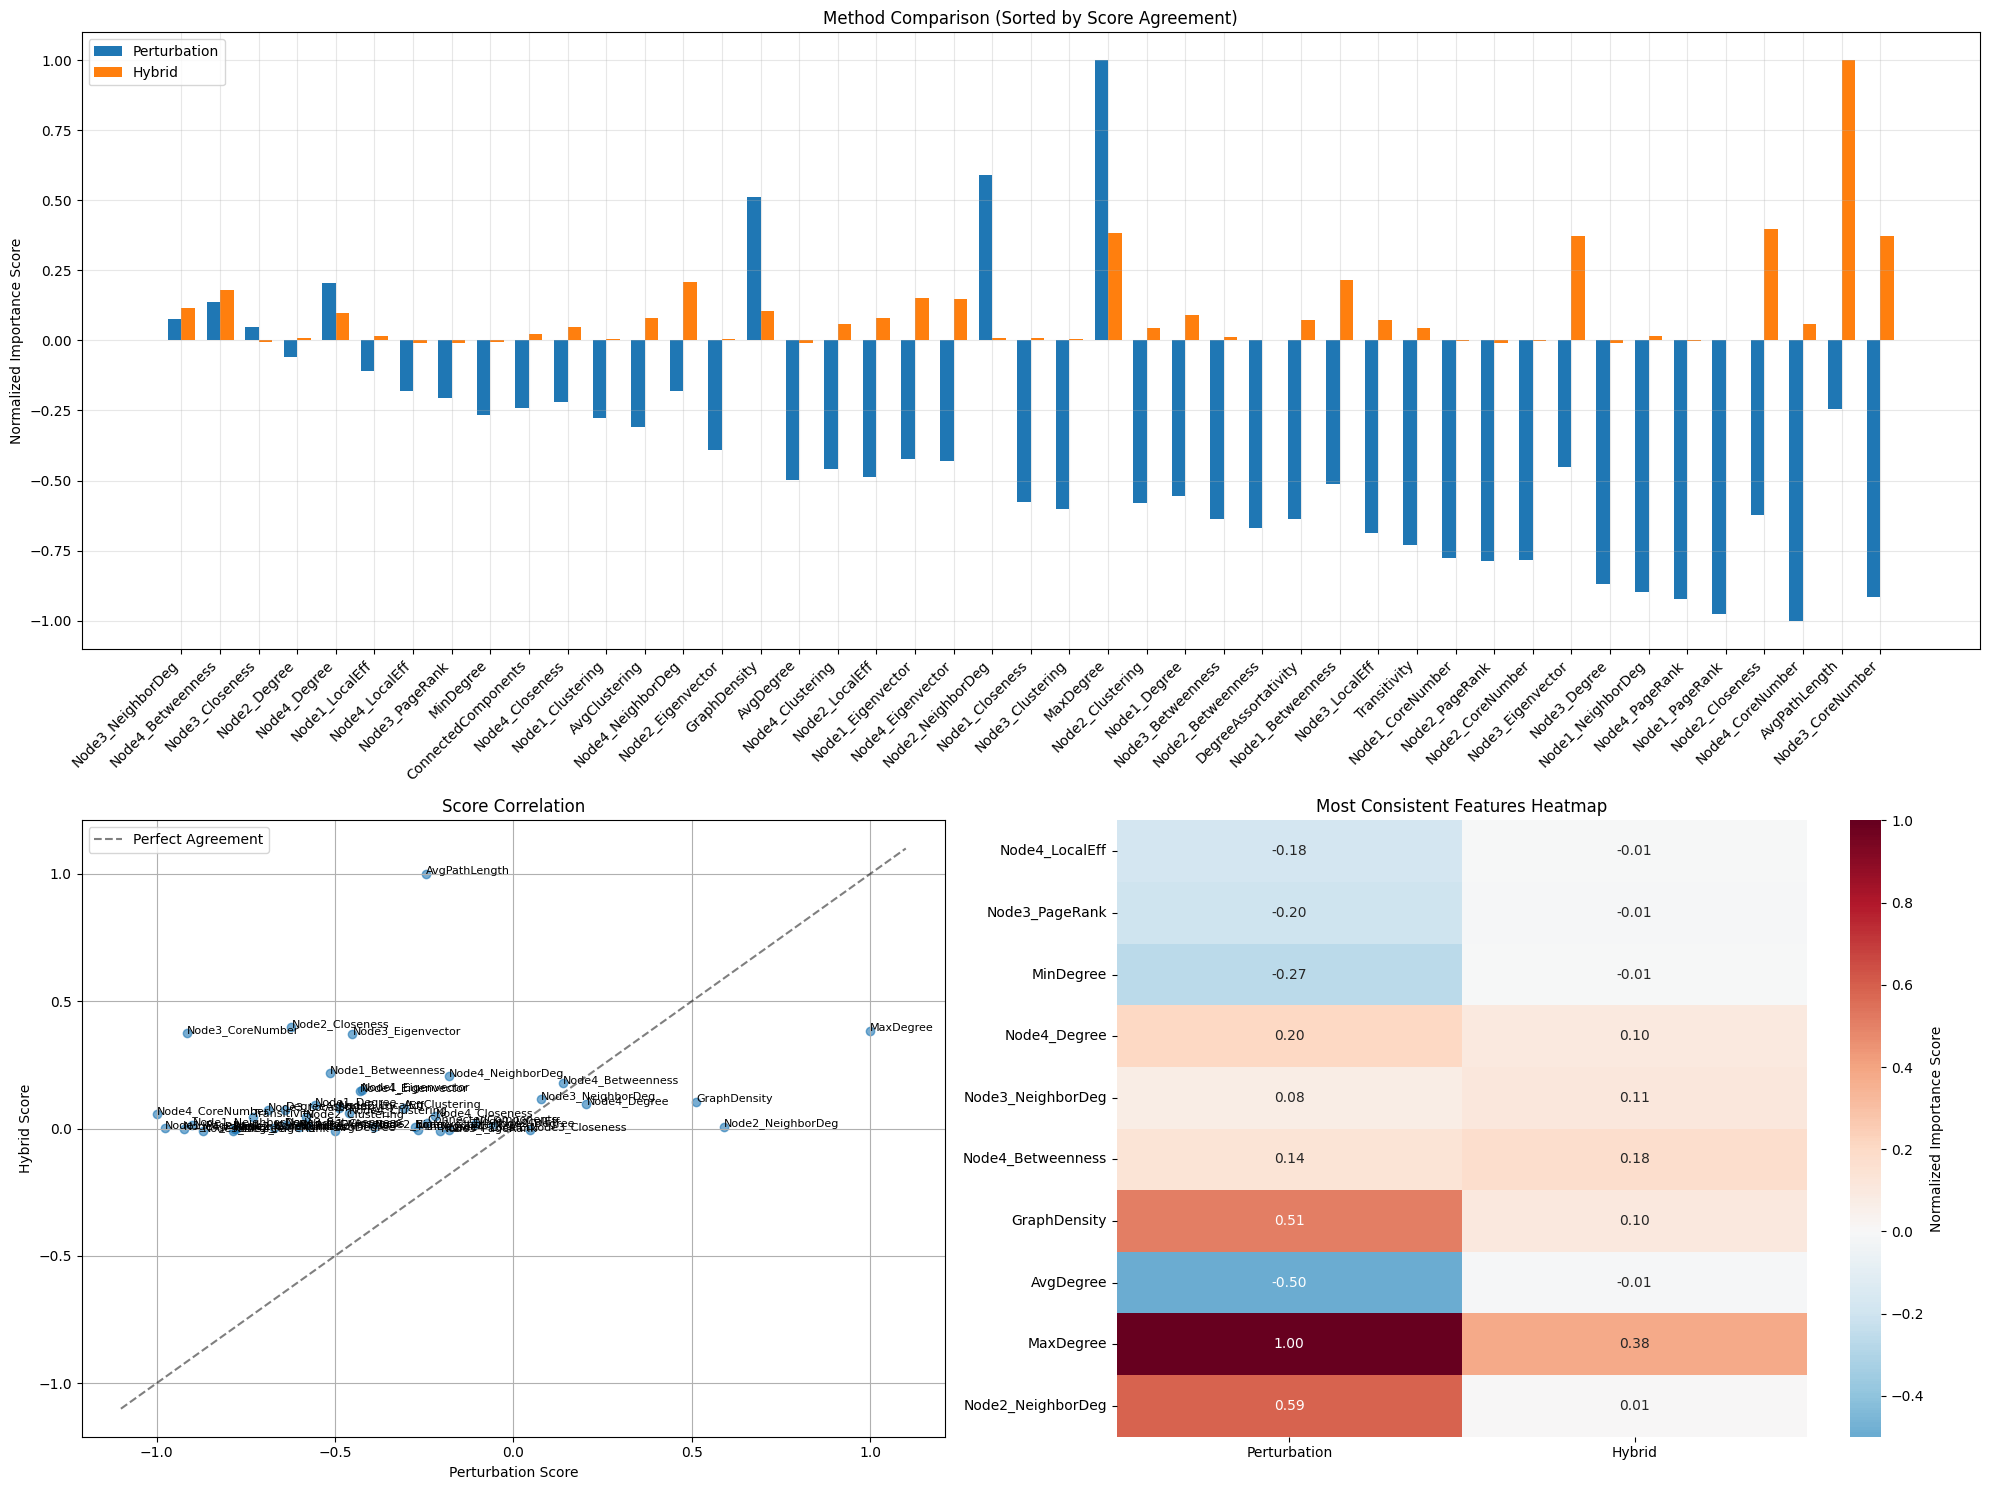

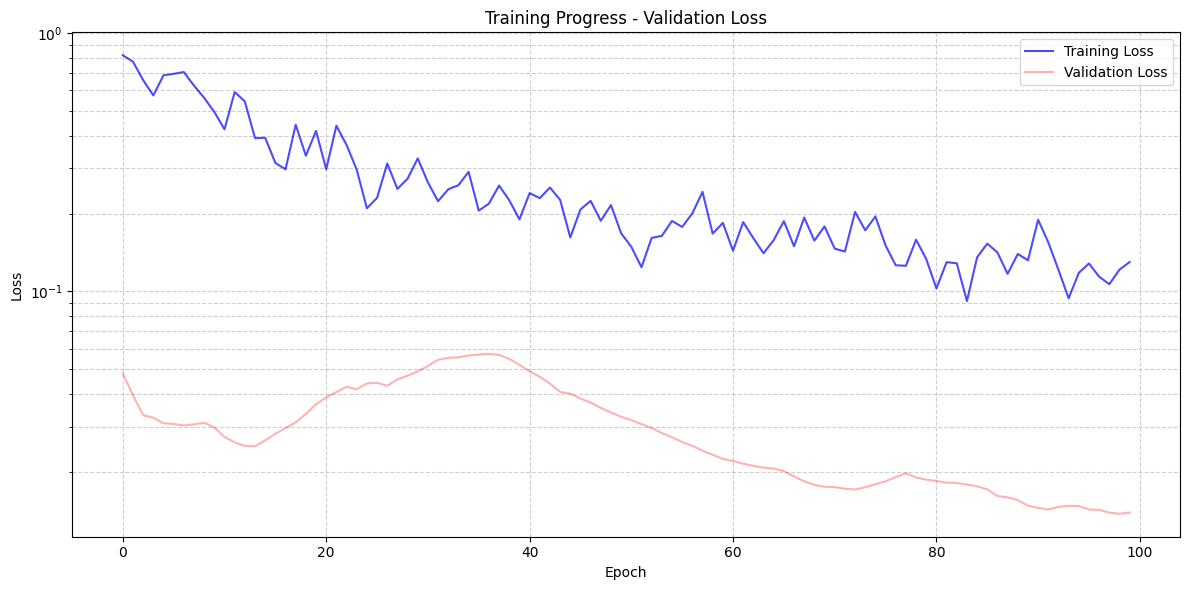

In [63]:
def main():
    # Generate random graph for analysis
    G, selected_nodes = generate_graph(num_nodes=100, edge_prob=0.05)
    
    # Select target feature for analysis
    target_feature = "Node1_Betweenness"
    target_idx = FEATURE_NAMES.index(target_feature)
    
    # Process graph data
    data = process_graph_data(G, selected_nodes, target_idx)
    
    # Initialize and train model
    model = SingleFeatureGNNModel(node_feature_dim=len(FEATURE_NAMES)-1)
    losses, trained_model = train_single_feature_model(
        model, 
        data, 
        target_idx
    )
    
    # Perform feature importance analysis
    compare_analysis_methods(
        G, 
        selected_nodes, 
        target_feature, 
        top_k=10
    )
    
    # Plot training progress
    plot_training_progress(losses)

if __name__ == "__main__":
    main()